<a href="https://colab.research.google.com/github/alvinkli/KaggleFashionCVAE/blob/main/Convolutional_VAE_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Variational Autoencoder Implementation on Kaggle Fashion Dataset**


###Introduction

Hey everyone! My name is Alvin Li. I am an MIT undergraduate student studying computer science and working as a deep learning researcher in the MIT Computer Science and Artificial Intelligence Lab (CSAIL). In this document, I will be detailing how I used TensorFlow to build, train, and test a convolutional variational autoencoder (VAE) on the Kaggle Fashion Dataset.

### Setup
To start, I went to the [Kaggle Website](https://www.kaggle.com/paramaggarwal/fashion-product-images-small) and clicked the "Download (565 MB)" button to download a zip file named "archive" that contains the Kaggle Fashion Product Images Dataset. This dataset is comprised of 44,000 high-resolution rgb images of fashion products along with their category labels. The former is stored in a folder named "images", and the latter is stored in a file named "styles.csv" (both are inside of the downloaded zip file). Next, I uploaded the zip file onto my Google Drive. This is much faster than opening up the zip file and uploading the entire dataset folder onto Google Drive. Lastly, I created a new [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) notebook, which is a free Jupyter notebook environment that allows you to write and execute Python and TensorFlow in your browser. 

*IMPORTANT NOTE: Before running any of the code below, complete these steps:*

*1) Click on the "Runtime" tab in the toolbar above.*

*2) Click "Change runtime type."*

*3) Make sure the Hardware Accelerator is set to "GPU" – this speeds up the training process by a lot.*

###Load Dataset and Import Relevant Packages
In order to access the contents of the zip file that I uploaded to my Google Drive, I "mounted" my Google Drive to my Colab Notebook. Running the code below outputs a prompt `Go to this URL in a browser:`. I clicked on the link, logged into my Google account, clicked "Allow", then copied the code and pasted it back into the Colab notebook in the input box under `Enter your authorization code:`. Mounting my Google Drive allows me to access any file on my Google Drive from this Colab notebook.




In [1]:
'''Allow Access to Google Drive Files'''
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, I imported all the necessary packages and unzipped the "archive" file from my Google Drive. The code below not only extracts the contents of the zip file, but also makes it so that I can view and access the files locally within this Colab notebook just by clicking the folder icon on the left toolbar.

In [3]:
'''Import Relevant Packages'''
import IPython
import tensorflow as tf
import functools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import glob
import pathlib
import cv2
import random
import logging
import scipy
from ipywidgets import interactive
import ipywidgets as widgets

from tqdm import tqdm

In [4]:
'''Unzip File Containing Kaggle Fashion Data'''
!unzip -q "/content/drive/MyDrive/archive.zip"

###Data Preprocessing

Originally, the images in the Kaggle Fashion dataset have dimensions 80 (height) x 60 (width) x 3 (RGB layers). I pre-processed the data by randomly shuffling the order of the images, downsizing each image to 64 x 64 x 3, and dividing each pixel value by 255 so that each pixel has a value between 0 and 1. This retains the important structural information of the images while reducing them to a form that can be better used to train and test a neural network.



Original Image: 



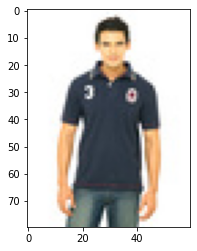


 Preprocessed Image: 



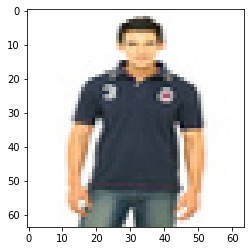


 There are 44010 images in the dataset.

 Each image has the dimensions (64, 64, 3).


In [5]:
'''Preprocess Data'''
#List of paths to each image file
data_dir = pathlib.Path('/content/images')
image_paths = list(data_dir.glob('*.jpg'))

#Shuffles the order of the images within the dataset
random.shuffle(image_paths)

#Displays the first image in the dataset
print("Original Image: \n")
plt.imshow(matplotlib.image.imread(image_paths[0]))
plt.show()

def preprocess_images(image_paths):
  images = []
  for image_path in image_paths:
    image = matplotlib.image.imread(image_path)
    resized_image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    if resized_image.shape == (64,64,3):
      resized_image = resized_image.reshape((64,64,3)) / 255
      images.append(resized_image.astype('float32'))
  return images

#List of images (each in the form of a 28x28x3 numpy array of rgb pixels)
images = preprocess_images(image_paths)

#Displays the first image in the dataset after preprocessing
print("\n Preprocessed Image: \n")
plt.imshow(images[0])
plt.show()

#Number of images in the entire dataset
print("\n There are " + str(len(images)) + " images in the dataset.")

#Dimensions of each image in the dataset
print("\n Each image has the dimensions " + str(images[0].shape) + ".")

I arbitrarily split the dataset into a set of training images (80% of the dataset) and a set of testing images (20% of the dataset).

In [10]:
'''Split Dataset into Training and Testing Data'''
train_images = np.array(images[0:int(len(images)*0.8)])
test_images = np.array(images[int(len(images)*0.8):])

train_size = train_images.shape[0]
test_size = test_images.shape[0]

###Define the Convolutional Variational Autoencoder Model


A variational autoencoder (VAE) is a neural network comprised of an encoder and a decoder. The encoder network takes in high dimensional input data and reduces it down to a set of parameters (mean and standard deviation) that describe the data's low dimenensional latent space. The decoder network samples from the parameters of the latent space to reconstruct the original input data.

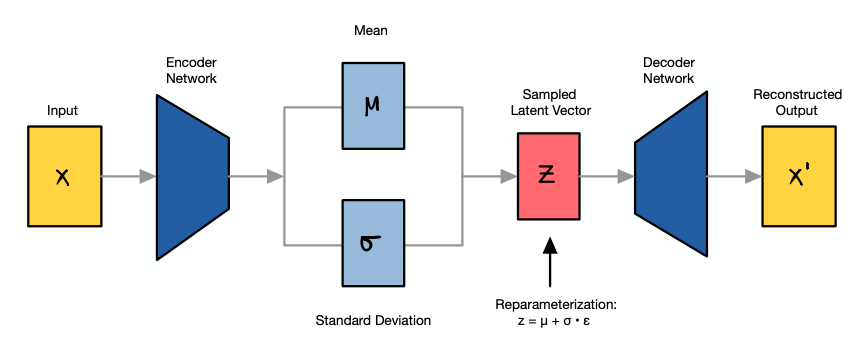

I used a convolutional neural network (CNN) for the encoder portion of the VAE. This includes four Conv2D layers that apply filters/kernels to the input image so that the encoder can extract features and learn a stochastic latent space for the decoder to sample from. They are each followed by a BatchNormalization layer to scale the activations and speed up the learning process. The last two layers are a Flatten layer that flattens the input image to a 1-d array and a fully connected Dense layer. Both the Conv2D layers and the Dense layer use the rectified linear unit (reLU) activation function, which introduces nonlinearities to the encoder  by outputting the input if the input is positive and outputing zero if the input is negative. A more detailed explanation of CNNs can be found in the [MIT 6.S191 Convolutional Neural Networks Tutorial](https://www.youtube.com/watch?v=iaSUYvmCekI&ab_channel=AlexanderAmini).

The decoder portion of the VAE includes a fully connected Dense layer, a Reshape layer, and four Conv2DTranspose layers that reconstruct the input image using the sampled latent variables. Both the Dense layer and the four Conv2dTranspose layers use the same reLU activation function as the layers in the encoder network.

In [11]:
'''Build the Encoder and Decoder Networks for the VAE '''
n_filters = 12 #Base number of convolutional filters
latent_dim = 100 #Number of latent variables

def make_encoder(n_outputs = 1):
  #Functionally define the different layer types
  Input = tf.keras.layers.InputLayer
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  #Build the encoder network using the Sequential API
  encoder = tf.keras.Sequential([
    Input(input_shape=(64, 64, 3)),

    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),

    Dense(2*latent_dim, activation=None),
  ])

  return encoder

def make_decoder():
  #Functionally define the different layer types
  Input = tf.keras.layers.InputLayer
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten

  #Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([

    Input(input_shape=(latent_dim,)),
                       
    Dense(units=4*4*6*n_filters),

    Reshape(target_shape=(4, 4, 6*n_filters)),

    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),

    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),

    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),

    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

I defined the convolutional variational autoencoder by subclassing TensorFlow's Model class (`tf.keras.Model`) and using the encoder network and decoder network from above. The `encode()` function feeds an input image "x" into the encoder network, which generates the mean and standard deviation vectors of the learned latent variables z. The `reparameterize()` function uses a stochastic variable $\epsilon$ ~ $Normal(0,1)$ to sample from the parameters of z. Reparameterization is necessary because it allows the network to sample from the latent space while keeping the parameters of z deterministic, which enables backpropagation through the neural network. The equation used to sample from the mean and standard deviation of the encoded latent variables is $ z = \mathbb{\mu} + e^{\left(\frac{1}{2} \cdot \log{\sigma}\right)}\circ \epsilon $

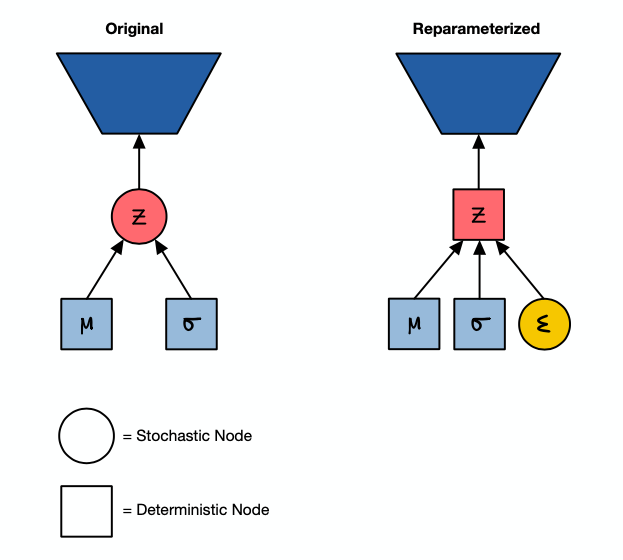

Lastly, the `decode()` function applies a sigmoid activation function to the reparameterized sample z before feeding it into the decoder network, which generates the final reconstruction image.

I also included a `call()` function that completes one forward pass through the entire model. This does everything above – encodes the input image, reparameterizes the latent variables, and decodes the sample to generate a reconstruction image.

*Note: A more detailed explanation of VAEs can be found in the [Towards Data Science Guide to Understanding VAEs](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)*

In [12]:
'''Convolutional Variational Autoencoder Class'''
class CVAE(tf.keras.Model):

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = make_encoder()
    self.decoder = make_decoder()

  def encode(self, x):
    z_mean, z_logsigma = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return z_mean, z_logsigma
  
  def reparameterize(self, z_mean, z_logsigma):
    eps = tf.random.normal(shape=z_mean.shape)
    return eps * tf.exp(z_logsigma * 0.5) + z_mean

  def decode(self, z, apply_sigmoid=False):
    x_recon = self.decoder(z)
    if apply_sigmoid:
      new_x_recon = tf.sigmoid(x_recon)
      return new_x_recon
    return x_recon

  def call(self, x): 
    z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    x_recon = self.decode(z)
    return z_mean, z_logsigma, x_recon

I defined the VAE loss function, which is the sum of the latent loss and the reconstruction loss. The latent loss uses the Kullback-Leibler (KL) divergence to measure how far the distribution of learned latent variables are from a unit Gaussian. The reconstruction loss uses the $L^1$ norm to measure how far the reconstructed output is from the original input image. These equations are given below:

Latent Loss: $ \displaystyle L_{KL}(\mu, \sigma) = \frac{1}{2}\sum\limits_{j=0}^{k-1}\small{(\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})} $

Reconstruction loss: $ \displaystyle  L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1 $


In [58]:
'''VAE Loss Function'''
def vae_loss_function(x, x_recon, z_mean, z_logsigma, kl_weight=0.0005):

  # latent_loss = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logsigma) + tf.square(z_mean) - 1.0 - z_logsigma, axis=1))
  # reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(0,1,2,3))
  # vae_loss = kl_weight * latent_loss + reconstruction_loss
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(z_logsigma) + tf.square(z_mean) - 1.0 - z_logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = tf.reduce_mean(kl_weight * latent_loss + reconstruction_loss)
  return vae_loss

###Train the VAE Model

I started the training process by initializing the batch size, learning rate, number of latent variables, and number of epochs. The current hyperparameter values have been optimized to balance the model's training speed with the accuracy of the reconstructed images.

Then, I initialized a new VAE model and an optimizer that uses the Adam optimization algorithm for stochastic gradient descent. 

Next, I defined a function `train_step` that completes a single step in the training process. This starts with a forward pass through the neural network that returns the parameters of the latent variables and the reconstructed image. These are inputted into the VAE loss function to calculate the total loss, which is added to `loss_history`. This Python list tracks the loss progression throughout the entire training process. Then, the gradient is calculated using TensorFlow's gradient tape. The Adam optimization algorithm takes in this gradient to perform gradient descent and reweights the trainable variables in the VAE.

Finally, I trained the VAE model. The training loop iterates through each epoch, batches the training data, and passes each batch of images into the train_step function.

In [59]:
'''Train the VAE Model'''
#Hyperparameters
batch_size = 256
learning_rate = 3e-4
latent_dim = 100
num_epochs = 100

#Instantiate a new CVAE model and optimizer
cvae = CVAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

#Record the total loss over time (updated during each step in the training process)
loss_history = []

def train_step(x, model):

  with tf.GradientTape() as tape:
    #Forward pass through the VAE
    z_mean, z_logsigma, x_recon = model.call(x)
    
    #Compute the loss
    loss = vae_loss_function(x, x_recon, z_mean, z_logsigma)

  #Calculate gradients
  grads = tape.gradient(loss, cvae.trainable_variables)

  #Apply gradients to variables using the Adam optimization algorithm
  optimizer.apply_gradients(zip(grads, cvae.trainable_variables))

  #Update record of losses
  loss_history.append(loss)

  return loss

#Training loop
for i in range(num_epochs):
 
  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  for j in tqdm(range(train_size // batch_size)):
    #Randomly selects a batch of images from the training dataset
    train_inds = np.random.permutation(np.arange(batch_size))
    selected_inds = np.random.choice(train_inds, size=batch_size, replace=False)
    sorted_inds = np.sort(selected_inds)
    batch_images = []
    for i in sorted_inds:
      batch_images.append(train_images[i])
    x = np.array(batch_images)

    #Completes a single step in the training process and optimizes the total loss
    loss = train_step(x, cvae)

  2%|▏         | 3/137 [00:00<00:04, 28.23it/s]

Starting epoch 100/100


100%|██████████| 137/137 [00:04<00:00, 30.02it/s]


###Test the VAE Model
To visualize the results of the neural network, I generated two grid-style plots that compare 16 input images within the testing dataset with their respective reconstructed outputs. If the reconstructed images turn out poorly, this means that the hyperparameters need to be adjusted. To help with that, I created a plot that displays the total loss over time during the model's training process.

Here are some general guidelines that I found useful for tuning these hyperparameters (number of epochs, batch size, learning rate, number of latent dimensions):

1) The loss should decrease steeply at the start and then plateau. If the line never evens out at the bottom, then the training process is incomplete, and the model needs to be retrained with a larger number of epochs.

2) If the loss decreases too slowly, increase the learning rate. If the loss changes erratically, decrease the learning rate. A good starting learning rate to use is 0.01.

3) Start with larger batch sizes and decrease it if needed. Larger batch sizes lead to a faster training process due to the parallelism of the GPUs, but they also result in a larger generalization error.

4) Typically the more complex the images are, the larger the number of latent dimensions needs to be (more latent variables).

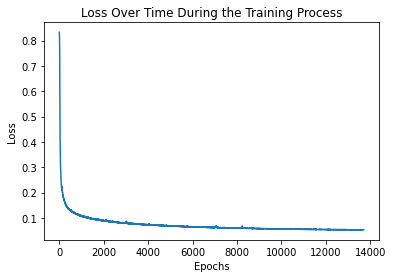

In [63]:
'''Plot Loss Over Time During the Training Process'''
plt.figure()
plt.plot(loss_history)
plt.title('Loss Over Time During the Training Process')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Original Images:


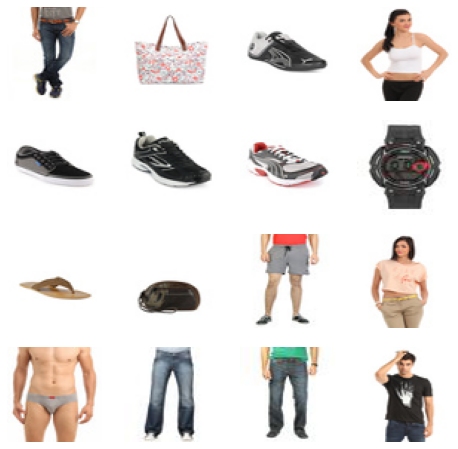


 Reconstructed Images:


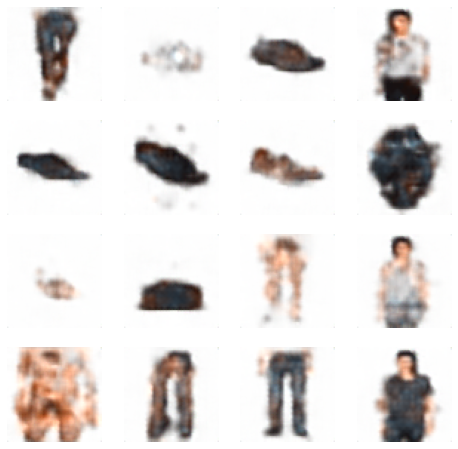

In [90]:
'''Plot Original Input Images vs. Reconstructed Images'''
def plot_original_images(test_sample):
  fig1 = plt.figure(figsize=(8, 8))

  for i in range(len(test_sample)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_sample[i])
    plt.axis('off')

  print('Original Images:')
  plt.show()

def plot_reconstructed_images(model, test_sample):
  z_mean, z_logsigma, x_recon = model.call(np.array(test_sample))

  fig1 = plt.figure(figsize=(8, 8))

  for i in range(x_recon.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_recon[i])
    plt.axis('off')

  print('\n Reconstructed Images:')
  plt.show()

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

test_sample = random.sample(list(test_images), 16)
plot_original_images(test_sample)
plot_reconstructed_images(cvae, test_sample)

# plot_original_images(test_images[0:16])
# plot_reconstructed_images(cvae, test_images[0:16])

logger.setLevel(old_level)

As you can see, the autoencoder is able to retain the general structure of each image during the encoding/decoding process after just 100 epochs of training. The results are fairly accurate even though some further optimizations may need to be made to clean up the colors within the reconstructed images.

*Note: The current model samples from a 100-dimensional latent space, but the quality of the reconstructed images persists even after reducing the number of latent dimensions down to 10 dimensions.*

###Final Remarks

In the next part of this project, I will experiment with a few methods to improve the performance of the convolutional variational autoencoder.

Method 1: Implement a perceptual loss function rather than a per-pixel loss function. So instead of comparing each pixel from the reconstructed output with the corresponding pixel in the ground truth image, a perceptual loss function feeds both the reconstructed output and the ground truth image into a pretrained neural network and computes the difference between their respective feature representations. A publication from [Stanford University](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) and another from [Luleå University of Technology](https://arxiv.org/pdf/2001.03444.pdf) propose that replacing per-pixel loss functions with perceptual loss functions when training an autoencoder network leads to better reconstructions.

Method 2: Convert the RGB images to HSV images inside of the VAE loss function and calculate a weighted mean of the errors across each color channel (hue, saturation, value) to determine the reconstruction loss. Weighting the pixel-wise errors in the "hue" channel higher than the errors in the "saturation" and "value" channels could result in reconstructions with more accurate colors.

After improving the quality of the reconstructions, I will explore the latent space with several different techniques. To start, I will generate a plot that displays images in the dataset and their respective reconstructions by querying directly from the latent space. To do this, I will need to use ipywidgets' interactive sliders to control the value of each latent variable. This interactive plot can be used to discover the individual features that each latent variable extracts from the images (ie. color, orientation, type of clothing). Afterwards, I'll generate a 3D representation of the entire latent space using a t-distributed stochastic neighbor embedding (t-SNE) algorithm, which allows us to visualise high-dimensional datasets in a lower dimensional space. 

All of these results will be published on my [GitHub](https://github.com/alvinkli)!

###Relevant Resources
Here are links to videos, articles, and documents that provide a more detailed explanation of the important deep learning concepts that were covered in this Colab Notebook:

1) [3Blue1Brown Introduction to Neural Networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
*   This series of videos gives one of the clearest explanations of neural networks that I have seen.

2) [MIT 6.S191 Deep Learning Course](https://www.youtube.com/watch?v=njKP3FqW3Sk&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&ab_channel=AlexanderAmini)
*   Lecture 1 (Introduction to Deep Learning) offers a great overview of the core concepts within deep learning.
*   Lecture 3 (Convolutional Neural Networks) goes into detail about how convolutional neural networks work and how they are used to extract features from images.
*   Lecture 4 (Deep Generative Modeling) provides a high level explanation of VAEs and how they can be applied to various deep learning fields.

3) [Towards Data Science Guide to Understanding VAEs](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
*   This article outlines both the basic intuition and deep mathematical concepts behind VAEs. The math is not essential to understanding the code I wrote, but is very interesting nonetheless if you want to truly understand how VAEs work.

4) [TensorFlow VAE Implementation on the MNIST dataset](https://www.tensorflow.org/tutorials/generative/cvae)
*   This tutorial shows how to use TensorFlow to build, train, and test a convolutional variational autoencoder on the famous MNIST datset of black and white images of handwritten numbers.

5) [MIT 6.S191 Debiasing VAE Lab](https://github.com/aamini/introtodeeplearning/blob/master/lab2/solutions/Part2_Debiasing_Solution.ipynb)
*   This lab inspired a lot of the code structure that I used to build and train the VAE model. I did not use the debiasing and facial detection aspects of the lab, but they are interesting to read about nonetheless.

6) [TensorFlow Docs](https://www.tensorflow.org/api_docs/python/tf/all_symbols) and [NumPy Quickstart Tutorial](https://numpy.org/devdocs/user/quickstart.html)
*   These documents can be used as a reference in case there is any confusion with the syntax in the code above.












###*Special thanks to Wilko Schwarting, Alexander Amini, Igor Gilitschenski, and Professor Daniela Rus for their mentorship.*